# Grape V1 Data Plots
The purpose of this notebook is to provide a one-stop shop for plotting data from the prototype of the Grape 1 Low-Cost Personal Space Weather Station. It's used for two purposes: to generate climatology figures and to serve as an interactive data analysis system via Binder. (If you are using it in the latter form, note that Binder does not enable changes to the notebook to be saved - you must generate your own local copy.) 

#### Update history: 
This notebook was created by Kristina KD8OXT on 10 March 2022.

#### CReDIT Acknowlegment
John Gibbons N8OBJ for hardware design, Bob Benedict KD8CGH for multiplot utilities.

In [1]:
import pandas as pd
import plotly.express as px
import datetime
# from datetime import time
from datetime import date
import time
import pytz
import numpy as np
import seaborn as sns; sns.set_theme()
import wget
import os
import matplotlib.pyplot as plt
# import tqdm 
import sys  
sys.path.insert(0, '/path/to/application/app/folder')
from Beacon import readheader                                     # local .py file

# Generate Data Overview
The first step is to pull the list of filenames from the server maintained by the WWV Amateur Radio Club, WW0WWV. We will then generate a pandas dataframe from the filename list using the split() function. This will tell us the earliest and latest dates of data collection; we can use these as the bounds of our analysis, or substitute in a smaller set of bounds. We'll use this to create a Gantt chart showing station availability, and maybe keograms of our data over time. While we're at it, we can also generate two versions of a station map: one static, to put in our paper; and one dynamic, showing which stations were active at a given point in time. 

## Pull list of filenames from server

In [2]:
# For now, we'll look at a list of filenames that was saved manually. 
f = open("filelist.txt", "r")
df = pd.DataFrame(f)
# s = print(f.readline()) # read the next line of the list
f.close
df

,0
0,2019-05-24T000000Z_N0000001_G1_EN91fh_FRQ_WWV5...
1,2019-05-24T000000Z_N0000001_G1_EN91fh_WWV5_gra...
2,2019-05-25T000000Z_N0000001_G1_EN91fh_FRQ_WWV5...
3,2019-05-25T000000Z_N0000001_G1_EN91fh_WWV5_gra...
4,2019-05-26T000000Z_N0000001_G1_EN91fh_FRQ_WWV5...
...,...
15185,2022-05-05T000000Z_N0000041_G1_EN80ex_WWV10_gr...
15186,2022-05-05T000000Z_N0000042_G1_JO81na_FRQ_WWV1...
15187,2022-05-05T000000Z_N0000042_G1_JO81na_WWV10_gr...
15188,2022-05-05T000000Z_N00010_G1_EN91ii_FRQ_WWV10....


In [3]:
# import pycurl
# username = "kd8oxt"
# password = "kE6z@&G@$4HnMNfK"
# # curl -u username:password https://wwvarc.org/node/37
# # curl 'https://wwvarc.org/node/37'

# import pycurl
# import certifi
# from io import BytesIO

# buffer = BytesIO()
# c = pycurl.Curl()
# c.setopt(c.USERPWD, 'kd8oxt:kE6z@&G@$4HnMNfK') # this pw is deprecated
# c.setopt(c.URL, 'https://wwvarc.org/node/37')
# c.setopt(c.WRITEDATA, buffer)
# c.setopt(c.CAINFO, certifi.where())
# c.perform()
# c.close()

# body = buffer.getvalue()
# # Body is a byte string.
# # We have to know the encoding in order to print it to a text file
# # such as standard output.
# print(body)

In [4]:
# import wget
# url = "https://wwvarc.org/node/37"
# # wget.download(url)
# curl -v -u 'apiuser:apipwd https://wwvarc.org/node/37'
# wget http://kd8oxt:kE6z@&G@$4HnMNfK@www.wwvarc.org/node/37

In [5]:
# Eliminate .pngs from our file list:
df = df[~df[0].str.contains('.png')]
df.columns =['Filename']
df2 = df['Filename'].str.split('_', expand=True)
df2.columns =['Datetime', 'Node', 'G', 'Grid Square', 'FRQ', 'Frequency']
df2 = df2.drop(columns=['FRQ']) # no information in this columnn
# df2['Frequency'] = df2['Frequency'].map(lambda x: x.lstrip('.csv\n')
# df['Frequency'] = df['Frequency'].str.replace(r'.csv\n', '')
df2["Frequency"] = df2["Frequency"].str.replace(".csv\n","")
df = pd.concat([df2, df], axis = 1) # concatenate dataframes horizontally
df['Datetime']= pd.to_datetime(df['Datetime']) # cast to datetime
# df['Datetime'][0] # checking data type
df['Node'] =df['Node'].str.strip("N")                 # Ditch the leading N on the node numbers
df['Node'] = df['Node'].astype(str).astype(int)       # Cast node number to int
df 

,Datetime,Node,G,Grid Square,Frequency,Filename
0,2019-05-24 00:00:00+00:00,1,G1,EN91fh,WWV5,2019-05-24T000000Z_N0000001_G1_EN91fh_FRQ_WWV5...
2,2019-05-25 00:00:00+00:00,1,G1,EN91fh,WWV5,2019-05-25T000000Z_N0000001_G1_EN91fh_FRQ_WWV5...
4,2019-05-26 00:00:00+00:00,1,G1,EN91fh,WWV5,2019-05-26T000000Z_N0000001_G1_EN91fh_FRQ_WWV5...
6,2019-05-27 00:00:00+00:00,1,G1,EN91fh,WWV5,2019-05-27T000000Z_N0000001_G1_EN91fh_FRQ_WWV5...
8,2019-05-28 00:00:00+00:00,1,G1,EN91fh,WWV5,2019-05-28T000000Z_N0000001_G1_EN91fh_FRQ_WWV5...
...,...,...,...,...,...,...
15180,2022-05-05 00:00:00+00:00,39,G1,EM73ut,WWV10,2022-05-05T000000Z_N0000039_G1_EM73ut_FRQ_WWV1...
15182,2022-05-05 00:00:00+00:00,40,S1,EM38ww,WWV5,2022-05-05T000000Z_N0000040_S1_EM38ww_FRQ_WWV5...
15184,2022-05-05 00:00:00+00:00,41,G1,EN80ex,WWV10,2022-05-05T000000Z_N0000041_G1_EN80ex_FRQ_WWV1...
15186,2022-05-05 00:00:00+00:00,42,G1,JO81na,WWV10,2022-05-05T000000Z_N0000042_G1_JO81na_FRQ_WWV1...


<AxesSubplot:xlabel='Frequency'>

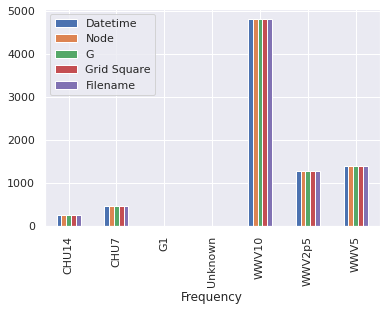

In [6]:
# We can generate bar graphs:
# df.groupby(df["Datetime"].dt.year).count().plot(kind="bar")
df.groupby(df["Frequency"]).count().plot(kind="bar")

In [16]:
# We can create a Gantt chart showing when different stations were active. 
gantt = df.copy()

# # # Filter by day:
sTime_tmp = datetime.datetime(2021,10,28, tzinfo = pytz.UTC)
eTime_tmp = datetime.datetime(2021,10,29, tzinfo = pytz.UTC)
# tf = gantt['Datetime'] >= sTime_tmp # true/false vector
gantt = gantt[(gantt['Datetime'] >= sTime_tmp) & (gantt['Datetime'] <= eTime_tmp)].copy()
# gantt = gantt[tf].copy()

# List of logged nodes during the period of interest, for sorting:
logged_nodes = df["Node"].unique().tolist()
logged_nodes.sort()

gantt.set_index('Node')
gantt = gantt.drop(columns=['G', 'Grid Square'])#, 'Filename'])
gantt['EndTime'] = gantt['Datetime']+ datetime.timedelta(days=1) # create an end
# For now, let's look at one frequency at a time.
# rows = gantt['Frequency']=='WWV5' # can change this to look at a different freq of interest.
# gantt = gantt.loc[gantt['Frequency'] == 'WWV2p5']

gantt['Filename'].str.strip('FRQ_')

# fig = px.timeline(gantt, x_start="Datetime", x_end="EndTime", y="Node", color="Frequency", text = "Filename", category_orders={"Node": logged_nodes})
fig = px.timeline(gantt, x_start="Datetime", x_end="EndTime", y="Node", color="Frequency", category_orders={"Node": logged_nodes})
# fig.update_yaxes(autorange="reversed") # otherwise tasks are listed from the bottom up
fig.update_yaxes(type='category')
fig.update_annotations(text = "Filename", clicktoshow='on')
# fig.update_layout(hovermode="x unified")

# for r in gantt.iterrows():
#     fig.add_annotation(
#         {
#             "x": r[1]["Datetime"],
#             "y": r[1]["EndTime"],
#             "text": r[1]["Filename"],
#         }
#     )



fig.show()
fig.write_html("gantt.html", include_plotlyjs="cdn")

In [8]:
# Read in node list:
nodes = pd.read_csv ('nodelist.csv',  encoding='cp1252')
nodes = nodes[1:42] # discarding extra rows - this should be dynamically assigned, but is manual for now.
nodes = nodes.rename(columns={'Node #': 'Node_Number'})

# Just the nodes that have data:
# logged_nodes = df["Node"].unique().tolist()
# logged_nodes.sort()
# logged_nodes = [s.lstrip('N') for s in logged_nodes]
test_list = list(map(int, logged_nodes)) # cast to int

# tf = nodes['Node #']logged_nodes[] # true/false vector
# nodes['Node #'] in logged_nodes
# nodes['Node #']
nodes['Status'] = np.where((nodes.Node_Number.isin(logged_nodes)), "Data logged", "No data logged")
nodes

color = (nodes['Status'] == 'No data logged').map({True: 'background-color: pink', False: ''})
nodes.style.apply(lambda s: color)

,Node_Number,Callsign,Name,Grid Square,Latitude,Longitude,Elevation (M),Radio,Antenna,System,Magnetometer,Temperature Sensor,Unnamed: 12,Status
1,1.000000,N8OBJ,John C. Gibbons,EN91fh,41.321963,-81.504739,285.000000,Grape Gen 1,DX Eng RF-PRO-1B Mag Loop /w N8OBJ preamp,"RasPi3B+, FLDigi 4.1.13",nan,nan,nan,Data logged
2,2.000000,AD8Y,David Kazdan,EN91fl,41.493744,-81.578039,300.000000,ICOM IC-7610,nan,"RasPi3B+, FLDigi 4.1.13",nan,nan,nan,Data logged
3,3.000000,N8OBJ,John C. Gibbons,EN91fh,41.321963,-81.504739,285.000000,Grape Gen 1,DX Eng RF-PRO-1B Mag Loop /w N8OBJ preamp,"RasPi3B+, FLDigi 4.1.13",nan,nan,nan,Data logged
4,4.000000,AD8Y,David Kazdan,EN91fl,41.493744,-81.578039,300.000000,Grape Gen 1,nan,"RasPi3B+, FLDigi 4.1.13",nan,nan,nan,Data logged
5,5.000000,KE8HPA,Frankie Bonte,EN80nd,40.130910,-82.847780,275.000000,DXF1200,nan,"RasPi3B+, FLDigi 4.1.09",nan,nan,nan,No data logged
6,6.000000,KD8OXT,Kristina Collins,EN91fl,41.498777,-81.573075,300.000000,DXF1200,nan,"RasPi3B+, FLDigi 4.1.09",nan,nan,nan,Data logged
7,7.000000,N8OBJ,John C. Gibbons,EN91fh,41.321963,-81.504739,285.000000,Grape Gen 1,DX Eng RF-PRO-1B Mag Loop /w N8OBJ preamp,"RasPi3B+, FLDigi 4.1.13",nan,nan,nan,Data logged
8,8.000000,AD8Y,David Kazdan,EN91fl,41.493744,-81.578039,300.000000,Grape Gen 1,nan,"RasPi3B+, FLDigi 4.1.13",nan,nan,nan,Data logged
9,9.000000,KB3UMD,Aidan Montare,FN20ge,40.176000,-75.493000,75.000000,Grape Gen 1,nan,"RasPi4B, FLDigi 4.1.13",nan,nan,nan,Data logged
10,10.000000,KD8SYG,James Niemann,EN91ii,,-81.283015,330.000000,Grape Gen 1,G5RV 80M 102' long,"RasPi4B, FLDigi 4.1.13",nan,nan,nan,Data logged


In [9]:
# Map nodes:
fig = px.scatter_geo(nodes, "Latitude", "Longitude",
                     color="Status", # which column to use to set the color of markers
                     hover_name=nodes["Callsign"], # column added to hover information
                     hover_data=[nodes["Node_Number"]], # this does not work
                     #size="Latitude", # size of markers
#                      projection = 'albers usa',
                     )
fig.update_layout(title="Stations")
fig.show()

## Example of a concurrent daily plot
Let's use the multiplot function developed by Bob Benedict KD8CGH (https://github.com/rkayakr/ProcessPlot) to plot Grape data from multiple stations on the same date. October 28, 2021 is a good example date, because there were solar flares widely observed by Grape 1 stations.

In [10]:
import wget
# path = '/data/'
url ="https://wwvarc.org/wwvarc.net/ftp/grape/2021-10-28T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv"
filename = wget.download(url)
filename
os.remove(filename) # delete the file from the working directory when we're done using it

In [26]:
# Gather multiple files....

sTime_tmp = datetime.datetime(2021,10,28, tzinfo = pytz.UTC)
eTime_tmp = datetime.datetime(2021,10,29, tzinfo = pytz.UTC)
# tf = gantt['Datetime'] >= sTime_tmp # true/false vector
namelist = gantt[(gantt['Datetime'] >= sTime_tmp) & (gantt['Datetime'] <= eTime_tmp)].Filename

names=namelist.values.tolist()

textfile = open("Processfiles.txt", "w")
for element in names:
    textfile.write(element + "\n")
textfile.close()

names



['2021-10-28T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv\n',
 '2021-10-28T000000Z_N0000002_S1_EN91fl_FRQ_WWV2p5.csv\n',
 '2021-10-28T000000Z_N0000003_G1_EN91fh_FRQ_WWV2p5.csv\n',
 '2021-10-28T000000Z_N0000004_S1_EN91fl_FRQ_CHU7.csv\n',
 '2021-10-28T000000Z_N0000007_G1_EN91fh_FRQ_WWV10.csv\n',
 '2021-10-28T000000Z_N0000008_S1_EN91fl_FRQ_WWV10.csv\n',
 '2021-10-28T000000Z_N0000013_S1_DN70ln_FRQ_WWV10.csv\n',
 '2021-10-28T000000Z_N0000014_G1_FN21ei_FRQ_WWV10.csv\n',
 '2021-10-28T000000Z_N0000015_G1_FN20mp_FRQ_WWV10.csv\n',
 '2021-10-28T000000Z_N0000034_G1_FN13wd_FRQ_WWV10.csv\n',
 '2021-10-28T000000Z_N0000035_C1_JO33lg_FRQ_CHU14.csv\n',
 '2021-10-28T000000Z_N0000036_G1_FN42hp_FRQ_WWV10.csv\n',
 '2021-10-28T000000Z_N00009_G1_FN20ge_FRQ_WWV10.csv\n',
 '2021-10-28T000000Z_N00010_G1_EN91ii_FRQ_WWV10.csv\n',
 '2021-10-28T001206Z_N0000029_G1_DM45dc_FRQ_WWV10.csv\n',
 '2021-10-29T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv\n',
 '2021-10-29T000000Z_N0000003_G1_EN91fh_FRQ_WWV2p5.csv\n',
 '2021-10-29T00000

In [ ]:
# Download the files to plot:

for name in names:
    stem = "https://wwvarc.org/wwvarc.net/ftp/grape/"
    url = stem + name
    filename = wget.download(url)

In [22]:
# # Load file into dataframe, ignore comment lines, and parse dates
# # fname = '2021-04-07T000000Z_N0000007_G1_EN91fh_FRQ_WWV10.csv.bz2'
# fname = "2021-10-28T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv"
# cfreq = 10e6
# data    = pd.read_csv(fname, comment = '#', parse_dates=[0])

# # Remove the 10 MHz offset from the frequency column.
# data['Freq'] = data['Freq']-cfreq





number of files 1
File 2021-10-28T000000Z_N0000002_S1_EN91fl_FRQ_WWV2p5.csv found!
Processing...
New Header String Detected

corrected UTCDTZ = 2021-10-28T000000Z
Plot for Decoded 2.5MHz WWV Beacon

Ready to start processing records

Doppler min:  -2.2420000000856817 ; Doppler max:  2.2549999998882413
dB min:  -55.71902641176117 ; dB max:  -22.345639588628604
2021-10-28
Plot File: multi2021-10-28T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv.png

Exiting python multi plot program gracefully


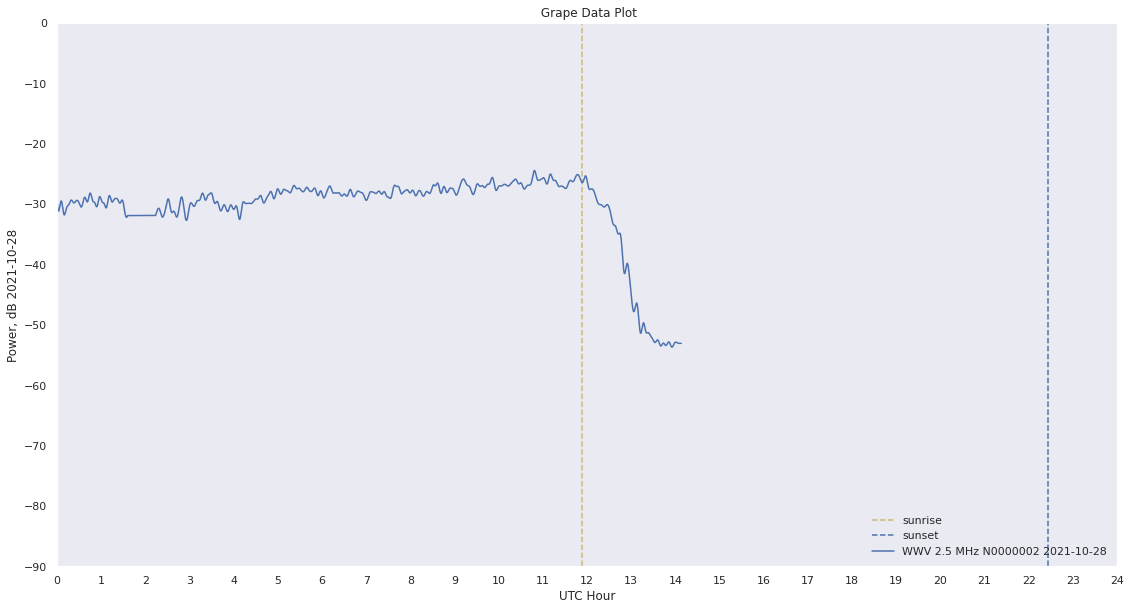

In [27]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
PROCESSED FILE VERSION V1.0 built on multiPlot v1.2
multiPlot version v1.2 cleans up to make Pi and Windows use easier
multiPlot version v1.1 adds sunrise sunset times for location of lat long in first file
requires suntime library https://github.com/SatAgro/suntime
multiPlot version v1.0 plots up to 10 PSWS "rawdata" files and average value
modified from WWV_plt2.py @authors dkazdan jgibbons
expects a homepath directory with processed files in homepath or subdirs 
leaves plot in Mplot directory
plots files from multiple subdir to compare node results
plot title from first file
windows version hardcoded homepath directory location
for Pi comment out windows homepath and uncomment Pi  lines
uses WWV_utility2.py
Bob Benedict, KD8CGH, 7/29/2021
create text file "plotfiles.txt" in homepath directory
  keyword ('Doppler' or 'Power')
  keyword ('Average' or 'No Average')
  subdir/filename1 
  subdir/filename2
  filename3
  ...
Note - expects all data from the same beacon
if found 'Doppler' will plot Doppler shifts, else will plot Power
if found "Average" will add average plot
loads file names in list
plots first file and create axis and title info
plots rest in loop as curves on first plot
calculates average and plots
leaves plotfile in Mplot directory
uses
WWV_utility2.py
20 February 2020
WWV utility file
Routines and classes used in WWV file management and graphing
David Kazdan, AD8Y
John Gibbons, N8OBJ - mods to plot header 2/3/20
"""

#import os # uncomment for pi
from os import path
import sys
import csv
import math
#import shutil  # uncomment for pi
#from datetime import date, timedelta  # uncomment for pi
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import filtfilt, butter
import datetime  
from suntime import Sun
#import subprocess
from WWV_utility2 import time_string_to_decimals
from Beacon import readheader

'''  #uncomment for Pi
# ~ points to users home directory - usually /home/pi/
homepath = os.path.expanduser('~')
# imbed the trailing / in the home path
homepath = homepath + "/PSWS/"
#comment out windows homepath
'''

homepath = ""#E:\\Documents\\PSWS\\"  # set your windows path, comment out for Pi

names = open(homepath+"Processfiles.txt","r")

PlotTarget = names.readline()
PlotTarget = PlotTarget.strip('\n')
PlotAverage = names.readline()
if PlotAverage[0:7] == 'Average':
    doavg=True
else:
    doavg=False

Filenames=['a' for a in range (10)]
Filedates=['a' for a in range (10)]
#PrFilenames=['a' for a in range (10)]
Nodenum=['a' for a in range (10)]
Beaconname=['a' for a in range (10)]
beaconfreq=np.zeros(10)

nfiles = 0  # holder for number of files to plot

colors=['b','g','r','c','m','y','tab:orange','tab:gray','tab:purple','tab:brown']

while True:
    temp = names.readline()
    if  len(temp) <= 1:
        break
    Filenames[nfiles]=temp.strip("\n")
    fdate = Filenames[nfiles].find("/") # find start of filename after subdirectory
    if fdate==-1 :  # if / not found try \
        fdate = Filenames[nfiles].find("\\")
#    print(" position ",fdate)
    # if neith / nor \ found file is in homepath, fdate=-1, following assignment still works
    Filedates[nfiles]=temp[fdate+1:fdate+11]
    nfiles=nfiles + 1
        
#print(Filenames[0:9])
#print(Filedates[0:9])
print('number of files',nfiles)
if nfiles > 10 :
    print('10 file limit')
    sys.exit(0)

PROCESSDIR = homepath

#saved plot directory
PlotDir = homepath + 'Mplot/'

'''
read first file
'''
PrFilenames=(PROCESSDIR + Filenames[0])

if (path.exists(PrFilenames)):
    print('File ' + PrFilenames + ' found!\nProcessing...')
else:
    print('File ' + PrFilenames + ' not available.\nExiting disappointed...')
    sys.exit(0)

with open(PrFilenames, 'r') as dataFile:
    dataReader=csv.reader(dataFile)
    data = list(dataReader)
    Header = data.pop(0)

#    print('return',readheader(0,Header))
    Nodenum[0], Beaconname[0], beaconfreq[0], Lat, Long = readheader(Header)
#    print('\n returned ', Nodenum[0], Beaconname[0], beaconfreq[0], Lat, Long, '\n')

''' ###########################################################################
'''
print('Ready to start processing records')

# Prepare data arrays
hours=[[],[],[],[],[],[],[],[],[],[]]
Doppler=[[],[],[],[],[],[],[],[],[],[]]
#Vpk=[[],[],[],[],[],[],[],[],[],[]]
Power_dB=[[],[],[],[],[],[],[],[],[],[]] # will be second data set, received power 9I20
filtDoppler=[[],[],[],[],[],[],[],[],[],[]]
filtPower=[[],[],[],[],[],[],[],[],[],[]]

LateHour=False # flag for loop going past 23:00 hours

# eliminate all metadata saved at start of file - Look for UTC (CSV headers)
#find first row of data0
FindUTC = 0

for row in data:
    if (FindUTC == 0):
        #print('looking for UTC - row[0] =',row[0])
        if (row[0] == 'UTC'):
            FindUTC = 1
#            print('UTC found =', row[0])
    else:
        #print('Processing record')
        decHours=time_string_to_decimals(row[0])
#        if (NewHdr != 'New'):
#            if (calccnt  < 101):
#                calcnt = calcnt+1
#                freqcalc = freqcalc + (float(row[1])/100)
#        if decHours > 23:
#            LateHour=True # went past 23:00 hours
        if (not LateHour) or (LateHour and (decHours>23)): # Otherwise past 23:59:59.  Omit time past midnight.
            hours[0].append(decHours) # already in float because of conversion to decimal hours.
            Doppler[0].append(float(row[1])-beaconfreq[0]) # frequency offset from col 2
#            Vpk[0].append (float(row[2])) # Get Volts peak from col 3
            Power_dB[0].append (20*math.log10(float(row[2]))) # log power from col 4

#print('nf ',0,'len hours',len(hours[0]))

###############################################################################################
# Find max and min of Power_dB for graph preparation:
min_power=np.amin(Power_dB[0]) # will use for graph axis min
max_power=np.amax(Power_dB[0]) # will use for graph axis max

min_Doppler=np.amin(Doppler[0]) # min Doppler
max_Doppler=np.amax(Doppler[0]) # max Doppler

print('\nDoppler min: ', min_Doppler, '; Doppler max: ', max_Doppler)
print('dB min: ', min_power, '; dB max: ', max_power)

#%% Create an order 3 lowpass butterworth filter.
# This is a digital filter (analog=False)
# Filtering at .01 to .004 times the Nyquist rate seems "about right."
# The filtering argument (Wn, the second argument to butter()) of.01
# represents filtering at .05 Hz, or 20 second weighted averaging.
# That corresponds with the 20 second symmetric averaging window used in the 1 October 2019
# Excel spreadsheet for the Festival of Frequency Measurement data.
#FILTERBREAK=.005 #filter breakpoint in Nyquist rates. N. rate here is 1/sec, so this is in Hz.
FILTERBREAK=0.005 #filter breakpoint in Nyquist rates. N. rate here is 1/sec, so this is in Hz.
FILTERORDER=6
b, a = butter(FILTERORDER, FILTERBREAK, analog=False, btype='low')
#print (b, a)
#%%
# Use the just-created filter coefficients for a noncausal filtering (filtfilt is forward-backward noncausal)


filtDoppler[0] = filtfilt(b, a, Doppler[0])

filtPower[0] = filtfilt(b, a, Power_dB[0])

##################################################################################################
# sunrise sunset times in UTC
sun = Sun(float(Lat), float(Long))

UTC_DT=Filedates[0]
print(UTC_DT)
SDAY=int(UTC_DT[8:10])
SMON=int(UTC_DT[5:7])
SYEAR=int(UTC_DT[0:4])
sdate = datetime.date(SYEAR, SMON, SDAY)
today_sr = sun.get_sunrise_time(sdate)
today_ss = sun.get_sunset_time(sdate)
#print(today_sr)
srh=int(format(today_sr.strftime('%H')))
srm=int(format(today_sr.strftime('%M')))
srx=srh+srm/60
ssh=int(format(today_ss.strftime('%H')))
ssm=int(format(today_ss.strftime('%M')))
ssx=ssh+ssm/60

# set up x-axis with time
fig = plt.figure(figsize=(19,10)) # inches x, y with 72 dots per inch
ax = fig.add_subplot(111)
ax.set_xlabel('UTC Hour')
ax.set_xlim(0,24) # UTC day
ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24], minor=False)

# plot first curve
if (PlotTarget == 'Doppler'):
    ax.plot([srx,srx],[-1,1],'y',label='sunrise',linestyle='dashed')
    ax.plot([ssx,ssx],[-1,1],'b',label='sunset',linestyle='dashed')
    ax.plot(hours[0], filtDoppler[0], colors[0],label=Beaconname[0] +' '+Nodenum[0]+' '+Filedates[0]) # color k for black
    ax.set_ylabel('Doppler shift, Hz '+ Filedates[0])
    ax.set_ylim([-1.0, 1.0]) # -1 to 1 Hz for Doppler shift
    plt.axhline(y=0, color="gray", lw=1) # plot a zero freq reference line for 0.000 Hz Doppler shift
    
    
else:
    ax.plot([srx,srx],[-90,0],'y',label='sunrise',linestyle='dashed')
    ax.plot([ssx,ssx],[-90,0],'b',label='sunset',linestyle='dashed')
    ax.plot(hours[0], filtPower[0], colors[0],label=Beaconname[0] +' '+ Nodenum[0]+' '+Filedates[0]) # color k for black
    ax.set_ylabel('Power, dB '+ Filedates[0])
    ax.set_ylim(-90, 0)    
    
    
# add grid lines - RLB
plt.grid(axis='both')

'''
######################################################################
read and plot files loop
'''

for nf in range(1, nfiles):
# splot second curve
# read second file, skip header
    print('process file ',nf, Filenames[nf])
    PrFilenames=(PROCESSDIR + Filenames[nf])
    with open(PrFilenames, 'r') as dataFile: # read second set
        dataReader=csv.reader(dataFile)
        data = list(dataReader)
        Header = data.pop(0)
        Nodenum[nf]= Header[2]
    FindUTC = 0
    
    Nodenum[nf], Beaconname[nf], beaconfreq[nf], Lat, Long = readheader(Header)
#    print('\n returned ', Nodenum[nf], Beaconname[nf], beaconfreq[nf], Lat, Long, '\n')

    for row in data:
        if (FindUTC == 0):
            #print('looking for UTC - row[0] =',row[0])
            if (row[0] == 'UTC'):
                FindUTC = 1
#            print('UTC found =', row[0])
        else:
            decHours=time_string_to_decimals(row[0])
            hours[nf].append(decHours) # already in float because of conversion to decimal hours.
            Doppler[nf].append(float(row[1])-beaconfreq[nf]) # frequency offset from col 2
#            Vpk[nf].append (float(row[2])) # Get Volts peak from col 3
#            Power_dB[nf].append (float(row[4])) # log power from col 4    
            Power_dB[nf].append (20*math.log10(float(row[2]))) # log power
# filter  file data
    filtDoppler[nf] = filtfilt(b, a, Doppler[nf])
    filtPower[nf] = filtfilt(b, a, Power_dB[nf])

    if (PlotTarget == 'Doppler'):    
        ax.plot(hours[nf], filtDoppler[nf], colors[nf], label=Beaconname[nf] +' '+ Nodenum[nf]+' '+Filedates[nf]) # color k for black
    else:
        ax.plot(hours[nf], filtPower[nf], colors[nf], label=Beaconname[nf] +' '+ Nodenum[nf]+' '+Filedates[nf]) # color k for black

'''
#############################################################################
end for read and plot loop, start average
'''
# find shortest data set, limit average to that
if doavg :
    al=1000000
    ak=0

    for k in range(nfiles):
        templ=len(hours[k])
        if templ < al:
            al=templ
            ak=k

    avg=[]

    if (PlotTarget == 'Doppler'):
        for i in range(al):
            temp=0.0
            for j in range(nfiles):
                temp=temp+filtDoppler[j][i]
            temp=temp/nfiles
            avg.append(temp)
    else:
        for i in range(al):
            temp=0.0
            for j in range(nfiles):
                temp=temp+filtPower[j][i]
            temp=temp/nfiles
            avg.append(temp)

    #print('avg',len(avg))

    ax.plot(hours[ak], avg, 'k', label='Average') # color k for black

'''
end average
'''
ax.legend(loc="lower right",  frameon=False)


# Create Plot Title
plt.title(' Grape Data Plot')
#plt.title(beaconlabel + ' Grape Data Plot\nNode:  ' + node + '     Gridsquare:  '+ GridSqr + '\nLat= ' + Lat + '    Long= ' + Long + '    Elev= ' + Elev + ' M\n' )
# Create Plot File Nam
#GraphFile = yesterdaystr + '_' + node + '_' + RadioID + '_' + GridSqr + '_' + beacon + '_graph.png'
GraphFile = 'multi'+ PlotTarget + '.png'
PlotGraphFile = PlotDir + GraphFile

# create plot
#plt.savefig(PlotDir + yesterdaystr + '_' + node + '_' +  GridSqr + '_' +  RadioID + '_' +  beacon + '_graph.png', dpi=250, orientation='landscape')
plt.savefig(PlotDir + GraphFile, dpi=250, orientation='landscape')
# =============================================================================

print('Plot File: ' + GraphFile + '\n')  # indicate plot file name for crontab printout


#-------------------------------------------------------------------
print('Exiting python multi plot program gracefully')

## Keogram of long-term data
Let's generate a keogram of data from AD8Y and N8OBJ, two stations relatively close to one another.

In [ ]:
# Code to create a table, called "keo", which includes the data for a station.

tic = time.time()                                                       # set up time clock to see how long this takes
# First we select stations of interest:
keolist = df[df['Node']==29]         # selecting one node
cfreq = 10e6 # 10 MHz.... will change if we want to look at another frequency.


# # Filter by days of interest:
sTime_tmp = datetime.datetime(2022,1,10, tzinfo = pytz.UTC)
tf = keolist['Datetime'] >= sTime_tmp # true/false vector
keolist = keolist[tf].copy()
keolist["Filename"]=keolist["Filename"].str.replace("\n","")

keofiles = keolist["Filename"].tolist() # generate a list of filenames
urls = ["https://wwvarc.org/wwvarc.net/ftp/grape/" + s for s in keofiles]

urls = urls[20:30] # for debugging - make it a short list. 

# For each url, download file, regularize, pull date from datestamp, convert datestamp to timestamp, 
# pd.merge() into keo, delete old file

keo = _                                # Renew keo variable
try:
    del keo
except NameError:
    print('No keo table to refresh.')
    
for url in urls:
    filename = wget.download(url)
    rawdata    = pd.read_csv(url, comment = '#', parse_dates=[0])
    data = rawdata.drop_duplicates(subset=['UTC'], keep='last')      # drop duplicates
    datestring = data['UTC'].iloc[4].date().strftime('%d %b %Y')     # what's the date?
    current_date = data['UTC'].iloc[4].date()
    data['UTC'] = pd.to_datetime(data['UTC'])                        # convert from string to datetime
    data = data.set_index(['UTC'])                                   # index by datetime
    data = data.resample('5min').pad()                               # Resample *within* for loop
    data.index = pd.Series([val.time() for val in data.index])       # Ditch date from datetime
    data = data.drop(columns = ['Vpk'])                              # let's just look at frequency information...
    data['Freq'] = data['Freq']-cfreq                                # Remove the 10 MHz offset from the freq column.
    Freq_string="freq: "+ datestring                                 # Rename col with date
    Vpk_string = "Vpk: " + datestring                                # Rename col with date
    data = data.rename(columns={'Freq': Freq_string, 'Vpk': Vpk_string})
    
    os.remove(filename) # delete the file from the working directory when we're done using it
    try: # put all data of interest into one
        
        while current_date > expected_date:        # Check and see if we missed a day.
            print('Missing a day!............. Expected ' + expected_date.strftime('%d %b %Y') +
                 ' but the next dataset is ' + current_date.strftime('%d %b %Y'))
            expected_date = expected_date+datetime.timedelta(days=1)
            print( "Let's check for " + expected_date.strftime('%d %b %Y'))
            data[:] = np.nan                                 # Pad with a blank day's worth of data
            keo = pd.concat([keo, data], axis=1)
        print('Merging data...' + current_date.strftime('%d %b %Y'))
        keo = pd.concat([keo, data], axis=1)                     
        expected_date = current_date+datetime.timedelta(days=1)
    except NameError:
        keo = data.copy(deep=True)
        print('Starting keo table...'+ current_date.strftime('%d %b %Y'))
        expected_date = current_date
        print('Starting date list. ' + expected_date.strftime('%d %b %Y'))
keo

toc = time.time() - tic                                     # See how much time has passed
print(str(toc) + ' seconds to complete this task.')         # Feedback to user


In [ ]:


color = plt.get_cmap('RdBu')   # default color

# cmap = copy.copy(mpl.cm.get_cmap("RdYlGn"))
color.set_bad('black')    # distinct color if value is bad. Try "lightblue" for something milder...
# h_map = sns.heatmap(data=N8OBJ, cmap=color, robust = 1, center = 0,  vmin=-.45, vmax=.45)   # now plot the heatmap
# plt.title('N8OBJ')


# list(N8OBJ)


In [ ]:
# AD8Y = keo.copy()
# h_map = sns.heatmap(data=AD8Y, cmap=color, robust = 1, center = 0,  vmin=-.45, vmax=.45)   # now plot the heatmap
# plt.title('AD8Y')
# list(AD8Y)
# AD8Y

In [ ]:
# # import plotly.plotly as py #import for online posted plots
# import chart_studio.plotly as py
# import numpy as np
# from scicolorscales import *

# def surface2():    
#     x = np.linspace(-2, 2, 200)
#     y = np.linspace(-2, 2, 200)
#     x,y = np.meshgrid(x, y)
#     z = 2*(x+y)*np.exp(-x**2-y**2)
#     return x, y, z

# data2=get_plotly_data(surface=surface2, colorscale=vik)
# layout['scene'].update(zaxis=dict(axes_style, **dict(range=[-2.5,1.5])),
#                        camera=dict(eye=dict(x=-1.25, y=1.25, z=0.6)))
# layout.update(title='Plot with vik colorscale')
# fig2=dict(data=data2, layout=layout)
# py.iplot(fig2, filename='scientific-divclsc')

In [ ]:
# h_map = sns.heatmap(data=N8OBJ.-AD8Y, cmap=color, robust = 1, center = 0,  vmin=-.45, vmax=.45)   # now plot the heatmap

In [ ]:
def keomaker(nodenum, start = [2018, 1, 1, 0, 0, 0], end = [date.today().year, date.today().month, date.today().day], 
             cfreq = 10e6, cadence = '5min', quant='freq'):
    tic = time.time()                                                       # set up time clock to see how long this takes
    # First we select stations of interest:
    keolist = df[df['Node']==nodenum]         # selecting one node


    # Filter by days of interest:
    sTime_tmp = datetime.datetime(start[0], start[1], start[2], tzinfo = pytz.UTC)
    tf1 = keolist['Datetime'] >= sTime_tmp
    eTime_tmp = datetime.datetime(end[0], end[1], end[2], tzinfo = pytz.UTC)
    tf2 = keolist['Datetime'] <= eTime_tmp
    tf = tf1 & tf2                                                                  
    keolist = keolist[tf].copy()
    keolist["Filename"]=keolist["Filename"].str.replace("\n","")
    

    keofiles = keolist["Filename"].tolist() # generate a list of filenames
    urls = ["https://wwvarc.org/wwvarc.net/ftp/grape/" + s for s in keofiles]

    # urls = urls[20:30] # for debugging - make it a short list. 

    # For each url, download file, regularize, pull date from datestamp, convert datestamp to timestamp, 
    # pd.merge() into keo, delete old file

    keo = _                                # Renew keo variable
    try:
        del keo
    except NameError:
        print('No keo table to refresh.')

    for url in urls:
        filename = wget.download(url)
        rawdata    = pd.read_csv(url, comment = '#', parse_dates=[0])
        data = rawdata.drop_duplicates(subset=['UTC'], keep='last')      # drop duplicates
        datestring = data['UTC'].iloc[4].date().strftime('%d %b %Y')     # what's the date?
        current_date = data['UTC'].iloc[4].date()
        data['UTC'] = pd.to_datetime(data['UTC'], utc=True)             # convert from string to datetime
        data = data.set_index(['UTC'])                                   # index by datetime
        data = data.resample(cadence).pad()                               # Resample *within* for loop
        data.index = pd.Series([val.time() for val in data.index])       # Ditch date from datetime

        if quant == 'amp':
            data = data.drop(columns = ['Freq'])
            print('Looking at amplitude.')
        if quant == 'freq':
            data = data.drop(columns = ['Vpk'])                              # let's just look at frequency information.
            data['Freq'] = data['Freq']-cfreq                                # Remove the 10 MHz offset from the freq column.
        Freq_string= datestring                                          # Rename col with date
        Vpk_string = "Vpk: " + datestring                                # Rename col with date
        data = data.rename(columns={'Freq': Freq_string, 'Vpk': Vpk_string})

        os.remove(filename) # delete the file from the working directory when we're done using it
        try: # put all data of interest into one

            while current_date > expected_date:        # Check and see if we missed a day.
                print('Missing a day!............. Expected ' + expected_date.strftime('%d %b %Y') +
                     ' but the next dataset is ' + current_date.strftime('%d %b %Y'))
                expected_date = expected_date+datetime.timedelta(days=1)
                print( "Let's check for " + expected_date.strftime('%d %b %Y'))
                data[:] = np.nan                                 # Pad with a blank day's worth of data
                keo = pd.concat([keo, data], axis=1)
            print('Merging data...' + current_date.strftime('%d %b %Y'))
            keo = pd.concat([keo, data], axis=1)                     
            expected_date = current_date+datetime.timedelta(days=1)
        except NameError:
            keo = data.copy(deep=True)
            print('Starting keo table...'+ current_date.strftime('%d %b %Y'))
            expected_date = current_date
            print('Starting date list. ' + expected_date.strftime('%d %b %Y'))

    toc = time.time() - tic                                     # See how much time has passed
    print(str(toc) + ' seconds to complete this task.')         # Feedback to user
    return keo


In [ ]:
# N8OBJ = keomaker(1, cfreq=5e6, end=[2020, 7, 1, 0, 0, 0])
# h_map = sns.heatmap(data=N8OBJ, cmap=color, robust = 1, center = 0,  vmin=-.45, vmax=.45)   # now plot the heatmap
# # AD8Y = keomaker(8)

# W7LUX = keomaker(29, cfreq=10e6, end = [2021, 6, 1, 0, 0, 0], quant = 'amp')
h_map = sns.heatmap(data=W7LUX, robust = 1)# cmap=color, robust = 1)# center = 0,  vmin=-.45, vmax=.45)   # now plot the heatmap

In [ ]:

# W7LUX = keomaker(29, cfreq=10e6, end = [2022, 1, 1, 0, 0, 0])
h_map = sns.heatmap(data=W7LUX, cmap=color, robust = 1, center = 0,  vmin=-.45, vmax=.45)   # now plot the heatmap
plt.title('W7LUX, 10 MHz')

In [ ]:
W7LUX

In [ ]:
N8OBJ2 = keomaker(7, cfreq=10e6)
h_map = sns.heatmap(data=N8OBJ2, cmap=color, robust = 1, center = 0,  vmin=-.45, vmax=.45)   # now plot the heatmap


In [ ]:
h_map = sns.heatmap(data=N8OBJ2, cmap=color, robust = 1, center = 0,  vmin=-.45, vmax=.45)   # now plot the heatmap
plt.title('Node 7 - N8OBJ, 10 MHz')

N8OBJ2

In [ ]:
N8OBJ3 = keomaker(7, start = [2022, 1, 10, 0, 0, 0], end = [2022, 1, 20, 0, 0, 0], cfreq=10e6, cadence = '1s')
h_map = sns.heatmap(data=N8OBJ3, cmap=color, robust = 1, center = 0,  vmin=-.45, vmax=.45)   # now plot the heatmap


In [ ]:
# Next steps:
#     1) Get keosaver bug fixed (flip start and end times above to test) so partial datasets can be incorporated
#    1.5) Sub in new node list from John - delete PII first - new filelist.txt too
#     2) Write for loop (below) to bulk gen keograms and save data
#     3) Make a version of keosaver to zoom in on sunrise only - higher time resolution/shorter cadence

In [ ]:
# nodes

# # N8OBJ2.to_csv('N8OBJ Node 7 10 MHz 5 min cadence.csv')
# for i in nodes:
#     nodes

nodes['Grid Square']

# Create Event List
## Pull Space WX Data from Other Sources
Let's also pull data from the NOAA database. We'll use this to generate our event list, selecting dates when, for instance, we saw solar flares that might induce Doppler flash and so on. We can also pull data showing seasonal or solar variation, like a history of the Kp index, which we can integrate into the visualizations we generated above. 

## List Events of Interest
We have certain events that we noticed produced interesting plots. Let's compile a list of them here, with annotations of why they're interesting. Then we'll use multiplot to make figures for them.